In [1]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline 

In [3]:
#Returns the average total transport and reaction time needed to succesfully incorporate amino acids
#in num_rib ribosomes (rxn13) in the voxel for experiments expt_start to expt_end. Only looks at events within
#simtime
def computeTransportRxnTimes(path,simtime, num_rib,expt_start,expt_end,avg=False):
    df_outputs = pandas.read_csv(path+"outputReactionsList.txt",sep=" ",header=None)
    transport_time = list()
    reaction_time = list()
    success_incorp = list()
    for expt_num, row in df_outputs.iterrows():
        succincorp_count = 0
        if(expt_num>=expt_start and expt_num<expt_end):
            df = pandas.read_csv(path+row[0],delimiter=" ",header=None)
            df.columns=["time","rxn","x","y","z","reactantA","productA","productB"]
            df=df.loc[df['rxn'].isin(["rxn10","rxn12","rxn13"])]
            df=df.loc[df['time']<simtime]
            df=df[['time','rxn']]

            transport_time_i = list()
            reaction_time_i = list()
            i=-1
            single_RxnTime = list() #Created to aggregate transport time between unsuccesful rxns into those btwn only succesful rxns
            single_TransportTime = list() #Created to aggregate transport time between unsuccesful rxns into those btwn only succesful rxns

            for _, row in df.iterrows():
                i+=1

                if(row["rxn"]=='rxn10' and succincorp_count<num_rib):
                    if(i>0):
                        single_TransportTime.append(row['time']-float(df.iloc[[i-1]]['time']))
                    else:
                        single_TransportTime.append(row['time'])

                if((row['rxn']=='rxn13'or row["rxn"]=='rxn12') and succincorp_count<num_rib):
                    single_RxnTime.append(row['time']-float(df.iloc[[i-1]]['time']))
                    if(row['rxn']=='rxn13'):
                        succincorp_count+=1
                        transport_time_i.append(sum(single_TransportTime))
                        reaction_time_i.append(sum(single_RxnTime))
                        single_TransportTime = list()
                        single_RxnTime = list()
                        
            #print(reaction_time_i)
            if(succincorp_count<num_rib and avg==True):
                transport_time_i = transport_time_i[:-1] #drops the last transport time if there wasn't a reaction recorded afterwards (else last transport time would be too short)
            transport_time.append(transport_time_i)
            reaction_time.append(reaction_time_i)
            success_incorp.append(succincorp_count)
         #   print(len(transport_time))
          #  print((reaction_time))

    return transport_time, reaction_time, success_incorp

def compute_avgtimes(data, simtime):
    avg_transport_time=list()
    avg_reaction_time=list()
    avg_succincorp = list()
   
    for i,data_i in enumerate(data):
        path = "/Users/Akshay/Dropbox/Life/EndyLab/Research/TranslationDynamics/data/"+data_i[0]+"/"
        transport_time, reaction_time,incorp_count = computeTransportRxnTimes(path, simtime, 100000, data_i[1],data_i[2],avg=True)
        avg_transport_time.append(np.average([np.average(l) for l in transport_time]))
       # print(([np.average(l) for l in transport_time]))
        avg_reaction_time.append(np.average([np.average(l) for l in reaction_time]))
        #print(([np.average(l) for l in reaction_time]))
        #print(np.divide(1,(np.add([np.average(l) for l in reaction_time],[np.average(l) for l in transport_time]))))
        avg_succincorp.append(np.average(incorp_count))
        #print((incorp_count))
        
    print( avg_transport_time,"\n",avg_reaction_time,"\n avg incorp:", avg_succincorp)
    return avg_transport_time, avg_reaction_time, avg_succincorp


def compute_totaltimes(data, simtime):
    total_transport_time=list()
    total_reaction_time=list()
    for i,data_i in enumerate(data):
        path = "/Users/Akshay/Dropbox/Life/EndyLab/Research/TranslationDynamics/data/"+data_i[0]+"/"
        transport_time, reaction_time,incorp_count = computeTransportRxnTimes(path, simtime, 100000, data_i[1],data_i[2])

        total_transport_time.append(np.average([np.sum(l) for l in transport_time]))
        total_reaction_time.append(np.average([np.sum(l) for l in reaction_time]))

    return total_transport_time,total_reaction_time

###Taking average elongation based on transport and reaction times is more accurate, as for the small
#amounts of time being simulated here, actual incorporation rate achieved by a simulated voxel will
#be prone to stochastic effects (since only a few total incorp events are happening). Thus, instead
#calculating the average transport time and reaction time per incorporation event is more accurate/robust
#for scaling up and estimating incorp rate/total incorp at longer time scales.
def compute_elongationtimes(avg_transport_time,avg_reaction_time, numrib_voxel,numrib_total):
    avg_elong = np.divide(1,(np.add(avg_transport_time,avg_reaction_time)))/numrib_voxel
    total_elong = avg_elong*numrib_total #right now, this is just multiplying by 62k so not that informative. bcz scaling tot ribosomes by # ribosomes in voxel...
    return avg_elong,total_elong
    

def plot_avgtimes(plt_rxn,plt_transport,total_rxn,total_transport,single_elong_rate,bulk_elong_rate):
    f,[ax1,ax2,ax3] = plt.subplots(1,3,figsize=(20,10))
    z=[1,2,3,4,5,6,7,8]
    cmap = matplotlib.cm.get_cmap('Blues')
    normalize = matplotlib.colors.Normalize(vmin=min(z)-1, vmax=max(z))
    colors = [cmap(normalize(value)) for value in z]

    ax1.scatter(np.multiply(plt_transport,1000),np.multiply(plt_rxn,1000), color=colors,s=60)
    # plt.colorbar('Blues')
    ax1.set_title("Influence of average transport vs. reaction time on translation rate\n at different ribosome abundances")
    ax1.set_xlabel('tau_reaction (ms)')
    ax1.set_ylabel('tau_transport (ms)')
    ax1.set_xlim(0,200)
    ax1.set_ylim(0,200)

    #Draw translation rate contour
    elongation_reaction_time = np.arange(500) #500
    elongation_transport_time = np.arange(500) #500

    x=list(([],[],[],[],[],[],[],[]))
    y=list(([],[],[],[],[],[],[],[]))

    for k in range(len(x)):
        for i in elongation_reaction_time:
            for j in elongation_transport_time:
                if(elongation_reaction_time[i]+elongation_transport_time[j]==50*(k+1) and i%5==0):
                    x[k].append(elongation_reaction_time[i])
                    y[k].append(elongation_transport_time[j])
        ax1.scatter(x[k],y[k],marker='.',color='black',alpha='0.6',s=10)
    
    ###############
    
    ax2.set_title("Influence of total transport vs. reaction time in\n overall elongation rate at different ribosome abundances")
    ax2.scatter(total_rxn,total_transport,color=colors,s=60)
    ax2.set_xlim(0,1)
    ax2.set_ylim(0,1)
    ax2.set_xlabel("Fraction of total time spent by cognate tRNA in a reaction")
    ax2.set_ylabel("Fraction of total time spent by cognate tRNA freely diffusing")

    ###############
    ax3.set_title("Bulk cellular elongation rate vs. elongation rate per ribosome\n at different ribosome abundances")
    ax3.scatter(single_elong_rate,bulk_elong_rate,color=colors,s=60)
    ax3.set_xlabel("Average aa incorporated per ribosome per second")
    ax3.set_ylabel("Average aa incorporoated by all ribosomes per second")
    ax3.set_xlim(0,7)
    ax3.set_ylim(0,250000)

    
#suggests that instant charging must be possible, or some other speedup. #425

[0.0814779026904762, 0.050285319233387527, 0.03273575660967515, 0.025882850488898147, 0.011198471889519423, 0.00987003275699282, 0.007752108573749599, 0.0068316737816438156] 
 [0.010248412636155512, 0.010876438232448113, 0.011629987070111049, 0.010943752794763992, 0.011429286321846133, 0.010987403676332167, 0.011021117386733193, 0.011900726369619894] 
 avg incorp: [11.2, 15.5, 22.5, 26.5, 43.5, 47.9, 53.1, 52.9]
hi [0.82516581, 0.7613780099999999, 0.70444175, 0.6814768700000002, 0.4847334200000001, 0.4705044899999997, 0.4108643700000001, 0.3545390400000001] [0.11269359000000001, 0.1694960900000001, 0.2604767500000001, 0.2893258299999998, 0.49352488, 0.5185974100000001, 0.5801234300000001, 0.6250097600000001] [0.9378594 0.9308741 0.9649185 0.9708027 0.9782583 0.9891019 0.9909878
 0.9795488]
[5.45099842 5.4500287  5.63497823 5.43085656 4.41935074 4.35859369
 4.09748847 3.81310301] [ 48280.27172793  72407.52411415  99819.61444251 120254.68095604
 195714.10420795 212325.77851685 235898.264

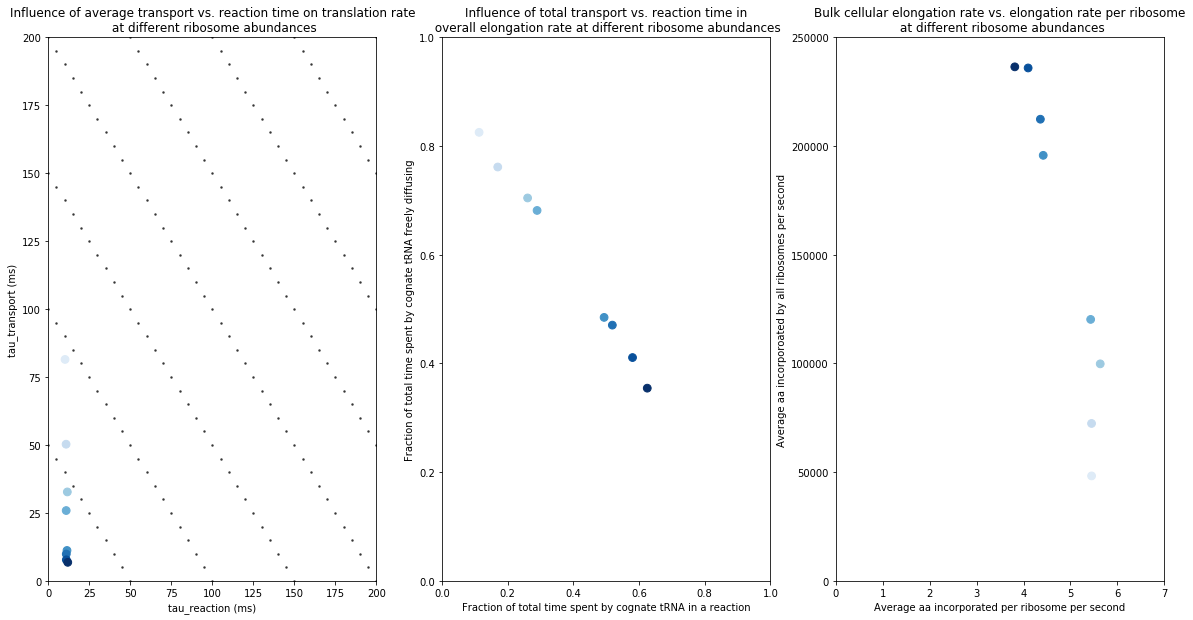

In [4]:
data=[["180906_2150",10,20],["180906_2321",10,20],["180907_1316",10,20],["180907_1509",10,20],["180907_1509",0,10],["180907_1316",0,10], ["180906_2321",0,10],["180906_2150",0,10]]
avg_transport_time, avg_reaction_time, avg_succincorp = compute_avgtimes(data,1)
total_transport_time,total_reaction_time = compute_totaltimes(data,1)
print("hi",total_transport_time,total_reaction_time,np.add(total_transport_time,total_reaction_time))
    
numrib_voxel = [2,3,4,5,10,11,13,14]
numrib_total=[62000*2/14,62000*3/14,62000*4/14,62000*5/14,62000*10/14,62000*11/14,62000*13/14,62000*14/14]
single_elong_rate, bulk_elong_rate=compute_elongationtimes(avg_transport_time, avg_reaction_time,numrib_voxel,numrib_total)
print(single_elong_rate,bulk_elong_rate)

plot_avgtimes(avg_transport_time,avg_reaction_time,total_reaction_time,total_transport_time,single_elong_rate, bulk_elong_rate)

[0.080864233333333327] 
 [0.0093569899999999869] 
 avg incorp: [10.0]
hi [0.83204309999999992] [0.093569899999999873] [ 0.925613]
[ 5.54193328  3.69462219  2.77096664  2.21677331  1.10838666  1.00762423
  0.85260512  0.79170475] [ 49085.69475066  49085.69475066  49085.69475066  49085.69475066
  49085.69475066  49085.69475066  49085.69475066  49085.69475066]


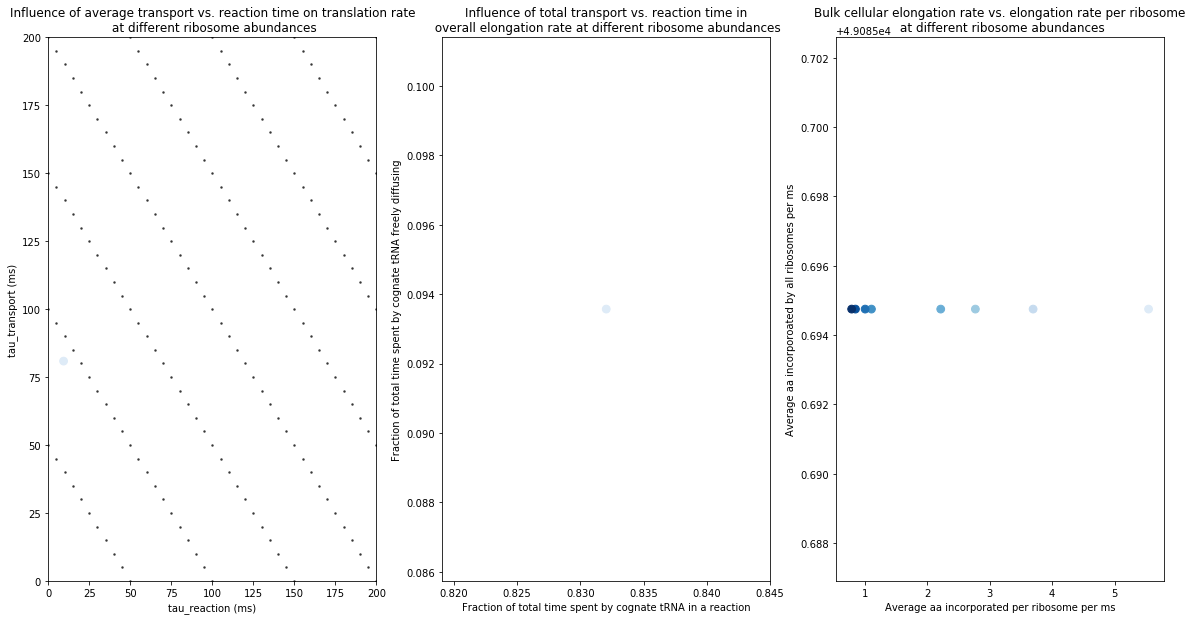

In [905]:
### Need to fix total_reaction_time so that it sums to 1 -- some bug fix needed ##
######Might just be the last bit of time is spent in a rxn10 but doesn't finish to rxn 13 in time#####
#####No, dont think this is the error..."
## Need to incorporate elongation rate into the total_trans vs total_rxn figure ##
## Need to incorporate a colorscale (some bug causing to crash) ##

data=[["180906_2150",18,19]]
avg_transport_time, avg_reaction_time, avg_succincorp = compute_avgtimes(data,1)
total_transport_time,total_reaction_time = compute_totaltimes(data,1)
print("hi",total_transport_time,total_reaction_time,np.add(total_transport_time,total_reaction_time))
    
numrib_voxel = [2,3,4,5,10,11,13,14]
numrib_total=[62000*2/14,62000*3/14,62000*4/14,62000*5/14,62000*10/14,62000*11/14,62000*13/14,62000*14/14]
single_elong_rate, bulk_elong_rate=compute_elongationtimes(avg_transport_time, avg_reaction_time,numrib_voxel,numrib_total)
print(single_elong_rate,bulk_elong_rate)

plot_avgtimes(avg_transport_time,avg_reaction_time, total_transport_time,total_reaction_time,single_elong_rate, bulk_elong_rate)

In [61]:
df = pandas.read_csv("/Users/Akshay/Dropbox/Life/EndyLab/Research/TranslationDynamics/data/expt-0-Reactions-20180910.csv",sep=" ",header=None)
df.columns=["time","rxn","x","y","z","reactantA","reactantB","productA","productB"]

def totalRibosomeCollisions(df):
    df=df[['time','reactantA','reactantB','x','y','z']]
    df = df.sort_values(by=['reactantA','time'])
    #with pandas.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df)
    reactantA_i = ""
    reactantB_i = ""
    collision=0
    for index, row in df.iterrows():
        if row["reactantA"] != reactantA_i or row["reactantB"] != reactantB_i:
            collision+=1
        reactantA_i = row["reactantA"]
        reactantB_i = row["reactantB"]
    print(collision)
    return collision

totalRibosomeCollisions(df)

              time  reactantA  reactantB         x         y         z
44    1.194800e-06          3          6  0.031620  0.043132  0.110487
45    1.194900e-06          3          6  0.031598  0.043084  0.110496
46    1.512900e-06          3          6  0.028100  0.038364  0.107870
47    1.514500e-06          3          6  0.027609  0.038430  0.107023
48    1.514600e-06          3          6  0.027550  0.038545  0.107042
49    1.514700e-06          3          6  0.027527  0.038515  0.106937
154   2.095300e-06          3          6  0.026750  0.039935  0.102832
155   2.095400e-06          3          6  0.026794  0.039893  0.102844
195   2.133700e-06          3          6  0.026681  0.041584  0.103447
196   2.133800e-06          3          6  0.026600  0.041590  0.103412
197   2.133900e-06          3          6  0.026767  0.041784  0.103363
198   2.134300e-06          3          6  0.026477  0.041773  0.103373
199   2.137600e-06          3          6  0.025923  0.041493  0.103521
200   

37

In [117]:
#Maybe create a 43 x 43 table that tracks the xyz position of last collision for each pair,
#and if the new collision is within 1 nm of location or some threshold, discard.
#Otherwise, what's happening is that 4 guys are vibrating against a ribosome, so their collisions
#don't seem consecutive? No but I should be counting this as consecutive....
import pandas
import numpy as np
def multiTotalRibosomeCollisions(datapath,ts,expt_start,expt_end):
    df_outputs = pandas.read_csv(datapath+"/outputReactionsList.txt",sep=" ",header=None)
    collisions = list()
    df_molpos = pandas.read_csv(datapath+"/outputMolPosList.txt",sep=" ",header=None)
    for expt_num, row in df_outputs.iterrows():
        if(expt_num>=expt_start and expt_num<expt_end):
            expt_path=datapath+"/"+row[0]
            molpos_path=datapath+"/"+df_molpos.iloc[expt_num].values[0]
            #print(expt_path)
            collisions.append(totalRibosomeCollisions(expt_path,molpos_path,ts))
    print(collisions)
    return np.average(collisions)

def totalRibosomeCollisions(path,molpos_path,ts):
    min_delta_time = 1e-9
    df = pandas.read_csv(path,delimiter=" ",header=None)
    df.columns=["time","rxn","x","y","z","reactantA","reactantB","productA","productB"]
    df = df.sort_values(by=['time','reactantA'])
    print(df.shape)
    df = df[df['time'] > 10e-9]  #Drop first 2 nanoseconds due to overlap of spheres at startup causing increased rxns
    df = df.iloc[0:] #test different time lengths
    print("adjusted shape ",df.shape)

    #df_molpos = pandas.read_csv(molpos_path,delimiter=" ",header=None)
    #df_molpos.columns=["time","species", "none","x","y","z","id"]
    #df_molpos["time"] = df_molpos["time"]-1 

    lookup = {}
    reacA_prev = ""
    reacB_prev = ""
    collision=0
    
    #i=0
    for index, row in df.iterrows():
        #i+=1
        reacA_i = row["reactantA"] 
        reacB_i = row["reactantB"]
        time_i = row['time']

        #if reacA_i != reacA_prev or reacB_i != reacB_prev:
        #reacA_xyz = df_molpos.loc[(df_molpos['id']==reacA_i) & (df_molpos['time'] == round(time_i*ts))][['x','y','z']].values[0]
        #reacB_xyz = df_molpos.loc[(df_molpos['id']==reacB_i) & (df_molpos['time'] == round(time_i*ts))][['x','y','z']].values[0]
        
        if (reacA_i,reacB_i) in lookup:
            if ((time_i-lookup[(reacA_i,reacB_i)][0] > min_delta_time)): #or (np.linalg.norm(lookup[(reacA_i,reacB_i)][1]-reacA_xyz) > 0.005) or (np.linalg.norm(lookup[(reacA_i,reacB_i)][2]-reacB_xyz) > 0.005)):
                collision+=1
                #if collision%50==0:
                    #print(collision)
                lookup[(reacA_i,reacB_i)] = [time_i]#,reacA_xyz,reacB_xyz]
                lookup[(reacB_i,reacA_i)] = [time_i]#,reacB_xyz,reacA_xyz] ###Adding both orders of key values since order of reactants doesnt matter, but shows up differently for collisions in smoldyn

        else:
            collision+=1
            lookup[(reacA_i,reacB_i)] = [time_i]#,reacA_xyz,reacB_xyz]
            lookup[(reacB_i,reacA_i)] = [time_i]#,reacB_xyz,reacA_xyz] ###Adding both orders of key values since order of reactants doesnt matter, but shows up differently for collisions in smoldyn

        reacA_prev = reacA_i
        reacB_prev = reacB_i
        #reacA_xyz_prev = reacA_xyz
        #reacB_xyz_prev = reacB_xyz

    #print(collision)
    return collision

path = "/Users/Akshay/Dropbox/Life/EndyLab/Research/TranslationDynamics/data/expt-8-Reactions-20180913.csv"
pathmolpos ="/Users/Akshay/Dropbox/Life/EndyLab/Research/TranslationDynamics/180912_1607/expt-9-Molpos-20180912.csv"
ts=1e10
totalRibosomeCollisions(path,pathmolpos,ts)
#2363; get rid of first 10 time steps. [average across every 10 timesteps should be similar] <--can validate check w/ this
###NEED TO START AT 1 TIME INSTEAD OF 0; maybe +1 to rounded times. or actually, just subtract 1 from molpos
#I need to 1) print df_molpos['time'] and the round at different places to verify right time is being got
#Compare against other assigned ts to make sure getting right thing
#when ts=0 vs ts=1-11 (correct) only makes difference of ~100; i think this means that most reactions are new rxns
#Compare collision in the else to collision in the lookuip. Also might mean i need to run more timesteps
#to get more lookup overlap. Should still be lots of repeat reactions when going from 1e11 to 1e12...!
#Validate with fewer molecules so can get more timesteps to test block average across diff blocks
#437,427,441; vs. 1034 (0 to 3000); vs.598 (1000 to 4000); vs.  475(2000to5000) vs. 459 (3000 to 6000) vs. 
#443 (4000 to 7000); so drop at least 5000. (~250 time steps here.)
#Calculate by dropping first ~250(of 10^-11) frames of any simulation (first ~2.5 ns). Then taking average of 
#blocks of time to validate that all the same --> use this number to scale up estimations. (if drop or taking blocks
#need to scale accordingly to the time in which collisions are measured.)
#Try all the error catching...e.g., changing timestep, sim time , etc.;; changing the 5k steps measure location...
#2314 vs 2363; with dropped: 1315 (1e11) vs 1406(1e10); of the 1315, 805 are new rxns while the rest (510) are repeat far enough 
#If just compare against 

##TRY SIMPLER, just check every nanosecond.

(7704, 9)
adjusted shape  (0, 9)


0

In [402]:
import pandas as pd
def totalCollisions(path):
    """[summary]
    
    [description]
    
    Arguments:
        path {[type]} -- [description]
    
    Returns:
        [type] -- [description]
    """
    min_delta_time = 1e-9
    print(path)
    df_chunker = pd.read_csv(path,delimiter=" ",header=None,chunksize=250000)
    overall_return_array = list([0,0,0])
    for df in df_chunker:
        returnArray=list()
        df.columns=["time","rxn","x","y","z","reactantA","reactantB","productA","productB"]
        df = df[df['time'] > 0.1e-6]  #Drop first 2 nanoseconds due to overlap of spheres at startup causing increased rxns
        #df = df.sort_values(by=['time','reactantA'])
        returnArray.append(df.shape[0])
        df = df.iloc[0:] #test different time lengths
        returnArray.append(df.shape[0])

        lookup = {}
        reacA_prev = ""
        reacB_prev = ""
        collision=0
     
        for index, row in df.iterrows():
            reacA_i = row["reactantA"] 
            reacB_i = row["reactantB"]
            time_i = row['time']

            if ((reacA_i,reacB_i) not in lookup) or ((time_i-lookup[(reacA_i,reacB_i)][0] > min_delta_time)): #Note, second part of or statement only evaluated if first is false, i.e. reacA and reacB in lookup.
                collision+=1
                lookup[(reacA_i,reacB_i)] = [time_i]
                lookup[(reacB_i,reacA_i)] = [time_i]

            reacA_prev = reacA_i
            reacB_prev = reacB_i
        returnArray.append(collision)
        overall_return_array = np.add(overall_return_array, returnArray)
        print(1)
    return overall_return_array
totalCollisions("/Users/Akshay/Dropbox/Life/EndyLab/Research/TranslationDynamics/data/expt-10-Reactions-20180919.csv")


/Users/Akshay/Dropbox/Life/EndyLab/Research/TranslationDynamics/data/expt-10-Reactions-20180919.csv
1


array([30232, 30232,  2706])

In [321]:
totalRibosomeCollisions("/Users/Akshay/Dropbox/Life/EndyLab/Research/TranslationDynamics/data/180914_1052/expt-94-Reactions-20180914.csv","test",-1)

(1075962, 9)
adjusted shape  (1063064, 9)


162117

In [134]:
import pickle as pkl
with open("/Users/Akshay/Dropbox/Life/EndyLab/Research/TranslationDynamics/data/analysis/expt-6-Reactions-20180914_collision_count.pkl", 'rb') as f:
    data = pkl.load(f)
print(data)

[(1691, 9), (1639, 9), 1437]


In [102]:
path = "/Users/Akshay/Dropbox/Life/EndyLab/Research/TranslationDynamics/data/"
data = "180913_1108"
data1 = "180913_1147"
ts=1e11
expts = [(0,5),(5,10),(10,15),(15,20)]
expts1 = [(0,5),(5,10)]
collisionCount = list()
for i in range(len(expts)):
    collisionCount.append(multiTotalRibosomeCollisions(path+data,ts,expts[i][0],expts[i][1]))
print(collisionCount)

for i in range(len(expts1)):
    collisionCount.append(multiTotalRibosomeCollisions(path+data1,ts,expts[i][0],expts[i][1]))
print(collisionCount)

(10240, 9)
adjusted shape  (9788, 9)
(9885, 9)
adjusted shape  (9444, 9)
(9838, 9)
adjusted shape  (9413, 9)
(10117, 9)
adjusted shape  (9667, 9)
(10015, 9)
adjusted shape  (9586, 9)
[9057, 8685, 8683, 8875, 8820]
(37579, 9)
adjusted shape  (36035, 9)
(37820, 9)
adjusted shape  (36201, 9)
(38020, 9)
adjusted shape  (36470, 9)
(37730, 9)
adjusted shape  (36065, 9)
(38651, 9)
adjusted shape  (36962, 9)
[12572, 12623, 12615, 12511, 12707]
(125426, 9)
adjusted shape  (121068, 9)
(130936, 9)
adjusted shape  (126063, 9)
(125733, 9)
adjusted shape  (121731, 9)
(122783, 9)
adjusted shape  (118733, 9)
(126842, 9)
adjusted shape  (122380, 9)
[12794, 12998, 13017, 12682, 13002]
(418970, 9)
adjusted shape  (407147, 9)
(407119, 9)
adjusted shape  (395967, 9)
(408860, 9)
adjusted shape  (396959, 9)
(391728, 9)
adjusted shape  (380623, 9)
(412351, 9)
adjusted shape  (401066, 9)
[13266, 13329, 12937, 12696, 12991]
[8824.0, 12605.6, 12898.6, 13043.799999999999]
(1278213, 9)
adjusted shape  (1243499, 9)

In [110]:
path = "/Users/Akshay/Dropbox/Life/EndyLab/Research/TranslationDynamics/data/"
data = "180913_1306"
ts=1e11
expts = [(0,5),(5,10),(10,15),(15,20)] #14ribosome+crowding;14ribosome;1ribosome+crowding;1ribosome
collisionCountCrowding = list()
for i in range(len(expts)):
    collisionCountCrowding.append(multiTotalRibosomeCollisions(path+data,ts,expts[i][0],expts[i][1]))
print(collisionCountCrowding)

(8297383, 9)
adjusted shape  (7548576, 9)
(8292485, 9)
adjusted shape  (7545502, 9)
(8310969, 9)
adjusted shape  (7553371, 9)
(3282844, 9)
adjusted shape  (2543729, 9)
(8264285, 9)
adjusted shape  (7528326, 9)
[1073176, 1074872, 1066492, 362578, 1058847]
(1219201, 9)
adjusted shape  (1108160, 9)
(1218616, 9)
adjusted shape  (1107277, 9)
(1219788, 9)
adjusted shape  (1108622, 9)
(1217810, 9)
adjusted shape  (1107961, 9)
(1218320, 9)
adjusted shape  (1107564, 9)
[8933, 8921, 8834, 9120, 8904]
(304674, 9)
adjusted shape  (270714, 9)
(298711, 9)
adjusted shape  (265838, 9)
(293909, 9)
adjusted shape  (263303, 9)
(296537, 9)
adjusted shape  (265276, 9)
(303290, 9)
adjusted shape  (271919, 9)
[8962, 8965, 9041, 9111, 9027]
(6491, 9)
adjusted shape  (5615, 9)
(6151, 9)
adjusted shape  (5140, 9)
(8320, 9)
adjusted shape  (7645, 9)
(6733, 9)
adjusted shape  (5992, 9)
(7277, 9)
adjusted shape  (6436, 9)
[193, 157, 218, 205, 175]
[927193.0, 8942.3999999999996, 9021.2000000000007, 189.599999999999

In [112]:
path = "/Users/Akshay/Dropbox/Life/EndyLab/Research/TranslationDynamics/data/"
data = "180913_1437"
ts=1e11
expts = [(0,5),(5,10),(10,15),(15,20)] #14ribosome+crowding;14ribosome;1ribosome+crowding;1ribosome
collisionCountCrowding2 = list()
for i in range(len(expts)):
    collisionCountCrowding2.append(multiTotalRibosomeCollisions(path+data,ts,expts[i][0],expts[i][1]))
print(collisionCountCrowding2)


(879629, 9)
adjusted shape  (806514, 9)
(880967, 9)
adjusted shape  (805539, 9)
(893238, 9)
adjusted shape  (820905, 9)
(876030, 9)
adjusted shape  (798600, 9)
(902067, 9)
adjusted shape  (824166, 9)
[171549, 169105, 178792, 167388, 180541]
(122525, 9)
adjusted shape  (111444, 9)
(122894, 9)
adjusted shape  (111855, 9)
(122594, 9)
adjusted shape  (111510, 9)
(122962, 9)
adjusted shape  (111725, 9)
(123102, 9)
adjusted shape  (111979, 9)
[21402, 21409, 21339, 21287, 21396]
(92883, 9)
adjusted shape  (82758, 9)
(92490, 9)
adjusted shape  (81885, 9)
(92781, 9)
adjusted shape  (82897, 9)
(95979, 9)
adjusted shape  (84701, 9)
(95046, 9)
adjusted shape  (83746, 9)
[8859, 8751, 8907, 9138, 9053]
(2026, 9)
adjusted shape  (1615, 9)
(2482, 9)
adjusted shape  (2128, 9)
(1105, 9)
adjusted shape  (963, 9)
(1362, 9)
adjusted shape  (1140, 9)
(1712, 9)
adjusted shape  (1506, 9)
[160, 235, 119, 134, 153]
[173475.0, 21366.599999999999, 8941.6000000000004, 160.19999999999999]


In [107]:
path = "/Users/Akshay/Dropbox/Life/EndyLab/Research/TranslationDynamics/data/"
data = "180913_1412"
ts=1e11
expts = [(0,5),(5,10),(10,15),(15,20)] #14ribosome+crowding;14ribosome;1ribosome+crowding;1ribosome
collisionCountCrowding1 = list()
for i in range(len(expts)):
    collisionCountCrowding1.append(multiTotalRibosomeCollisions(path+data,ts,expts[i][0],expts[i][1]))
print(collisionCountCrowding1)

(7991, 9)
adjusted shape  (7044, 9)
(7958, 9)
adjusted shape  (6895, 9)
(7581, 9)
adjusted shape  (6580, 9)
(7884, 9)
adjusted shape  (6869, 9)
(7611, 9)
adjusted shape  (6674, 9)
[6372, 6225, 5998, 6219, 6034]
(28105, 9)
adjusted shape  (24644, 9)
(28117, 9)
adjusted shape  (24771, 9)
(30179, 9)
adjusted shape  (26420, 9)
(29286, 9)
adjusted shape  (25977, 9)
(28314, 9)
adjusted shape  (24849, 9)
[8455, 8672, 9054, 8857, 8505]
(92465, 9)
adjusted shape  (82219, 9)
(96024, 9)
adjusted shape  (84654, 9)
(97735, 9)
adjusted shape  (87021, 9)
(96314, 9)
adjusted shape  (85033, 9)
(90931, 9)
adjusted shape  (80217, 9)
[8821, 9078, 9157, 9006, 8728]
(300932, 9)
adjusted shape  (268044, 9)
(303839, 9)
adjusted shape  (271420, 9)
(312158, 9)
adjusted shape  (279190, 9)
(302612, 9)
adjusted shape  (267844, 9)
(297297, 9)
adjusted shape  (263911, 9)
[9011, 8982, 9023, 9008, 8892]
[6169.6000000000004, 8708.6000000000004, 8958.0, 8983.2000000000007]


In [114]:
path = "/Users/Akshay/Dropbox/Life/EndyLab/Research/TranslationDynamics/data/"
data = "180913_1636"
ts=1e11
expts = [(0,4),(4,8),(8,12),(12,16),(16,20)] #14ribosome+crowding;14ribosome;1ribosome+crowding;1ribosome
collisionCountCrowding4 = list()
for i in range(len(expts)):
    collisionCountCrowding4.append(multiTotalRibosomeCollisions(path+data,ts,expts[i][0],expts[i][1]))
print(collisionCountCrowding4)


(1367, 9)
adjusted shape  (1227, 9)
(1429, 9)
adjusted shape  (1285, 9)
(1399, 9)
adjusted shape  (1268, 9)
(1416, 9)
adjusted shape  (1274, 9)
[1201, 1261, 1236, 1249]
(12533, 9)
adjusted shape  (11410, 9)
(12754, 9)
adjusted shape  (11568, 9)
(12527, 9)
adjusted shape  (11351, 9)
(12614, 9)
adjusted shape  (11451, 9)
[7195, 7150, 7155, 7148]
(122371, 9)
adjusted shape  (111088, 9)
(123196, 9)
adjusted shape  (112116, 9)
(123051, 9)
adjusted shape  (111731, 9)
(122470, 9)
adjusted shape  (111191, 9)
[21369, 21219, 21362, 21322]
(1217444, 9)
adjusted shape  (1107090, 9)
(1220575, 9)
adjusted shape  (1109612, 9)
(1217602, 9)
adjusted shape  (1107439, 9)
(1215897, 9)
adjusted shape  (1105640, 9)
[8970, 8843, 9021, 8996]
(12136133, 9)
adjusted shape  (11033666, 9)
(12142423, 9)
adjusted shape  (11037810, 9)
(12140644, 9)
adjusted shape  (11037418, 9)
(12138226, 9)
adjusted shape  (11034193, 9)
[861, 861, 861, 862]
[1236.75, 7162.0, 21318.0, 8957.5, 861.25]


In [119]:
#new with updates to time tracking
path = "/Users/Akshay/Dropbox/Life/EndyLab/Research/TranslationDynamics/data/"
data = "180913_1636"
ts=1e11
expts = [(0,4),(4,8),(8,12),(12,16),(16,20)] #14ribosome+crowding;14ribosome;1ribosome+crowding;1ribosome
collisionCountCrowding5 = list()
for i in range(len(expts)):
    collisionCountCrowding5.append(multiTotalRibosomeCollisions(path+data,ts,expts[i][0],expts[i][1]))
print(collisionCountCrowding5)


#14 ribosomes may be too many and they're always colliding causing issues? But checking every 1e-9 shouldn't cause issues...
# why are tehre more collisions with 14 ribosomes and no crowders than with 1 ribosome and 400 crowders??

(1367, 9)
adjusted shape  (1227, 9)
(1429, 9)
adjusted shape  (1285, 9)
(1399, 9)
adjusted shape  (1268, 9)
(1416, 9)
adjusted shape  (1274, 9)
[1202, 1262, 1239, 1249]
(12533, 9)
adjusted shape  (11410, 9)
(12754, 9)
adjusted shape  (11568, 9)
(12527, 9)
adjusted shape  (11351, 9)
(12614, 9)
adjusted shape  (11451, 9)
[7848, 7873, 7782, 7836]
(122371, 9)
adjusted shape  (111088, 9)
(123196, 9)
adjusted shape  (112116, 9)
(123051, 9)
adjusted shape  (111731, 9)
(122470, 9)
adjusted shape  (111191, 9)
[33523, 33317, 33435, 33439]
(1217444, 9)
adjusted shape  (1107090, 9)
(1220575, 9)
adjusted shape  (1109612, 9)
(1217602, 9)
adjusted shape  (1107439, 9)
(1215897, 9)
adjusted shape  (1105640, 9)
[71250, 71120, 71107, 71124]
(12136133, 9)
adjusted shape  (11033666, 9)
(12142423, 9)
adjusted shape  (11037810, 9)
(12140644, 9)
adjusted shape  (11037418, 9)
(12138226, 9)
adjusted shape  (11034193, 9)
[84439, 84444, 84440, 84438]
[1238.0, 7834.75, 33428.5, 71150.25, 84440.25]


In [121]:
#Checking different time steps & crowding with the same seed to check effect of crowding on time scale neccessary
path = "/Users/Akshay/Dropbox/Life/EndyLab/Research/TranslationDynamics/data/"
data = "180913_2325"
ts=-10
expts = [(0,5),(5,10),(10,15),(15,20)] #14ribosome+crowding;14ribosome;1ribosome+crowding;1ribosome
collisionCountCrowding5 = list()
for i in range(len(expts)):
    collisionCountCrowding5.append(multiTotalRibosomeCollisions(path+data,ts,expts[i][0],expts[i][1]))
print(collisionCountCrowding5)


#14 ribosomes may be too many and they're always colliding causing issues? But checking every 1e-9 shouldn't cause issues...
# why are tehre more collisions with 14 ribosomes and no crowders than with 1 ribosome and 400 crowders??

(267, 9)
adjusted shape  (201, 9)
(832, 9)
adjusted shape  (650, 9)
(2277, 9)
adjusted shape  (1895, 9)
(9227, 9)
adjusted shape  (7542, 9)
(26562, 9)
adjusted shape  (22748, 9)
[173, 267, 256, 401, 343]
(7746, 9)
adjusted shape  (6760, 9)
(28613, 9)
adjusted shape  (25256, 9)
(90028, 9)
adjusted shape  (79615, 9)
(293395, 9)
adjusted shape  (261872, 9)
(949140, 9)
adjusted shape  (844755, 9)
[6173, 11023, 12385, 13142, 13595]
(358, 9)
adjusted shape  (281, 9)
(863, 9)
adjusted shape  (692, 9)
(2453, 9)
adjusted shape  (2133, 9)
(8072, 9)
adjusted shape  (6359, 9)
(31232, 9)
adjusted shape  (27654, 9)
[238, 287, 326, 330, 448]
(8471, 9)
adjusted shape  (7446, 9)
(32068, 9)
adjusted shape  (28253, 9)
(107198, 9)
adjusted shape  (95395, 9)
(343162, 9)
adjusted shape  (305051, 9)
(1173502, 9)
adjusted shape  (1051671, 9)
[6823, 12528, 14746, 15203, 16610]
[288.0, 11263.6, 325.80000000000001, 13182.0]


In [122]:
##1e8 1e9 1e10 1e11 1e12 for 1 ribosome, no crowding# #####

#Checking different time steps & crowding with the same seed to check effect of crowding on time scale neccessary
#Repeat of 2325 except with 5 repeats with different seeds for each repeat (but same 5 seeds across diff time steps)
path = "/Users/Akshay/Dropbox/Life/EndyLab/Research/TranslationDynamics/data/"
data = "180914_1052"
ts=-10
expts = [(0,5),(5,10),(10,15),(15,20),(20,25)] #14ribosome+crowding;14ribosome;1ribosome+crowding;1ribosome
collisionCountCrowding5 = list()
for i in range(len(expts)):
    collisionCountCrowding5.append(multiTotalRibosomeCollisions(path+data,ts,expts[i][0],expts[i][1]))
print(collisionCountCrowding5)

(531, 9)
adjusted shape  (508, 9)
(550, 9)
adjusted shape  (528, 9)
(530, 9)
adjusted shape  (508, 9)
(468, 9)
adjusted shape  (450, 9)
(530, 9)
adjusted shape  (508, 9)
[508, 528, 508, 450, 508]
(2029, 9)
adjusted shape  (1969, 9)
(1691, 9)
adjusted shape  (1639, 9)
(1724, 9)
adjusted shape  (1684, 9)
(1771, 9)
adjusted shape  (1727, 9)
(1543, 9)
adjusted shape  (1489, 9)
[1728, 1437, 1473, 1530, 1294]
(5102, 9)
adjusted shape  (4977, 9)
(5345, 9)
adjusted shape  (5213, 9)
(6620, 9)
adjusted shape  (6533, 9)
(5881, 9)
adjusted shape  (5784, 9)
(5715, 9)
adjusted shape  (5599, 9)
[2040, 2177, 2686, 2385, 2321]
(18570, 9)
adjusted shape  (18270, 9)
(18070, 9)
adjusted shape  (17853, 9)
(15436, 9)
adjusted shape  (15151, 9)
(18449, 9)
adjusted shape  (18221, 9)
(19280, 9)
adjusted shape  (19007, 9)
[2779, 2726, 2244, 2689, 2911]
(58900, 9)
adjusted shape  (57798, 9)
(59105, 9)
adjusted shape  (58174, 9)
(57937, 9)
adjusted shape  (57325, 9)
(51376, 9)
adjusted shape  (50881, 9)
(58047, 9

In [123]:
##1e8 1e9 1e10 1e11 1e12 for 1 ribosome, 427 crowding# #####

#Checking different time steps & crowding with the same seed to check effect of crowding on time scale neccessary
#Repeat of 2325 except with 5 repeats with different seeds for each repeat (but same 5 seeds across diff time steps)
path = "/Users/Akshay/Dropbox/Life/EndyLab/Research/TranslationDynamics/data/"
data = "180914_1052"
ts=-10
expts = [(25,30),(30,35),(35,40),(40,45),(45,50)] #14ribosome+crowding;14ribosome;1ribosome+crowding;1ribosome
collisionCountCrowding5 = list()
for i in range(len(expts)):
    collisionCountCrowding5.append(multiTotalRibosomeCollisions(path+data,ts,expts[i][0],expts[i][1]))
print(collisionCountCrowding5)



(13015, 9)
adjusted shape  (12755, 9)
(13179, 9)
adjusted shape  (12917, 9)
(13081, 9)
adjusted shape  (12820, 9)
(13228, 9)
adjusted shape  (12967, 9)
(13216, 9)
adjusted shape  (12955, 9)
[12755, 12917, 12820, 12967, 12955]
(74586, 9)
adjusted shape  (73552, 9)
(74222, 9)
adjusted shape  (73215, 9)
(73682, 9)
adjusted shape  (72688, 9)
(73235, 9)
adjusted shape  (72238, 9)
(73907, 9)
adjusted shape  (72922, 9)
[67767, 67526, 66878, 66502, 67283]
(275957, 9)
adjusted shape  (272421, 9)
(278201, 9)
adjusted shape  (274674, 9)
(274306, 9)
adjusted shape  (270596, 9)
(279231, 9)
adjusted shape  (275465, 9)
(274103, 9)
adjusted shape  (270675, 9)
[118557, 119410, 117418, 119787, 117354]
(913566, 9)
adjusted shape  (903184, 9)
(898240, 9)
adjusted shape  (887081, 9)
(905496, 9)
adjusted shape  (894799, 9)
(902670, 9)
adjusted shape  (891979, 9)
(916197, 9)
adjusted shape  (905052, 9)
[138928, 136242, 137110, 137587, 139007]
(2879594, 9)
adjusted shape  (2846290, 9)
(2899400, 9)
adjusted s

In [126]:
##1e8 1e9 1e10 1e11 1e12 for 3 ribosome, no crowding# #####

#Checking different time steps & crowding with the same seed to check effect of crowding on time scale neccessary
#Repeat of 2325 except with 5 repeats with different seeds for each repeat (but same 5 seeds across diff time steps)
path = "/Users/Akshay/Dropbox/Life/EndyLab/Research/TranslationDynamics/data/"
data = "180914_1052"
ts=-10
expts = [(50,55),(55,60),(60,65),(65,70),(70,75)] #14ribosome+crowding;14ribosome;1ribosome+crowding;1ribosome
collisionCountCrowding5 = list()
for i in range(len(expts)):
    collisionCountCrowding5.append(multiTotalRibosomeCollisions(path+data,ts,expts[i][0],expts[i][1]))
print(collisionCountCrowding5)


(693, 9)
adjusted shape  (672, 9)
(679, 9)
adjusted shape  (659, 9)
(655, 9)
adjusted shape  (632, 9)
(677, 9)
adjusted shape  (657, 9)
(620, 9)
adjusted shape  (598, 9)
[672, 659, 632, 657, 598]
(2156, 9)
adjusted shape  (2081, 9)
(2287, 9)
adjusted shape  (2215, 9)
(2460, 9)
adjusted shape  (2390, 9)
(2298, 9)
adjusted shape  (2228, 9)
(2419, 9)
adjusted shape  (2349, 9)
[1840, 1958, 2128, 1967, 2066]
(7092, 9)
adjusted shape  (6928, 9)
(5986, 9)
adjusted shape  (5830, 9)
(7031, 9)
adjusted shape  (6867, 9)
(6411, 9)
adjusted shape  (6294, 9)
(7140, 9)
adjusted shape  (6965, 9)
[2871, 2378, 2827, 2632, 2820]
(22819, 9)
adjusted shape  (22217, 9)
(22291, 9)
adjusted shape  (22033, 9)
(23920, 9)
adjusted shape  (23648, 9)
(23601, 9)
adjusted shape  (23322, 9)
(25218, 9)
adjusted shape  (24767, 9)
[3359, 3303, 3497, 3407, 3632]
(67715, 9)
adjusted shape  (66250, 9)
(66333, 9)
adjusted shape  (65502, 9)
(76620, 9)
adjusted shape  (75745, 9)
(74612, 9)
adjusted shape  (73341, 9)
(71846, 9

In [125]:
##1e8 1e9 1e10 1e11 1e12 for 3 ribosome, 427 crowding# #####

#Checking different time steps & crowding with the same seed to check effect of crowding on time scale neccessary
#Repeat of 2325 except with 5 repeats with different seeds for each repeat (but same 5 seeds across diff time steps)
path = "/Users/Akshay/Dropbox/Life/EndyLab/Research/TranslationDynamics/data/"
data = "180914_1052"
ts=-10
expts = [(75,80),(80,85),(85,90),(90,95),(95,100)] #14ribosome+crowding;14ribosome;1ribosome+crowding;1ribosome
collisionCountCrowding5 = list()
for i in range(len(expts)):
    collisionCountCrowding5.append(multiTotalRibosomeCollisions(path+data,ts,expts[i][0],expts[i][1]))
print(collisionCountCrowding5)


(13227, 9)
adjusted shape  (12978, 9)
(13395, 9)
adjusted shape  (13132, 9)
(13168, 9)
adjusted shape  (12920, 9)
(13562, 9)
adjusted shape  (13311, 9)
(13388, 9)
adjusted shape  (13123, 9)
[12978, 13132, 12920, 13311, 13123]
(315054, 9)
adjusted shape  (310971, 9)
(320683, 9)
adjusted shape  (316532, 9)
(313785, 9)
adjusted shape  (309684, 9)
(318044, 9)
adjusted shape  (314002, 9)
(316353, 9)
adjusted shape  (312383, 9)
[135609, 138936, 136340, 137739, 136788]
(1054797, 9)
adjusted shape  (1042383, 9)
(1057517, 9)
adjusted shape  (1045119, 9)
(1075738, 9)
adjusted shape  (1062995, 9)
(1073951, 9)
adjusted shape  (1060985, 9)
(1075962, 9)
adjusted shape  (1063064, 9)
[159179, 159745, 162414, 161495, 162117]
(3409538, 9)
adjusted shape  (3372590, 9)
(3426628, 9)
adjusted shape  (3384260, 9)
(3452437, 9)
adjusted shape  (3410713, 9)
(3324883, 9)
adjusted shape  (3285698, 9)
(3418340, 9)
adjusted shape  (3380619, 9)
[167731, 168305, 170021, 164095, 168615]
[13092.799999999999, 137082.399

In [8]:
import pickle as pkl
import glob

def collisionPickleAggregator(datapath, expts):
    collision_count=list()
    avg_coll_count = list()
    for expt_i in expts:
        data_arr_j=list()
        count_arr_j=list()
        for j in range(expt_i[0],expt_i[1]):
            try:
                collision_expt_path =glob.glob(datapath+'/analysis/expt-'+str(j)+'-*')[0]
                with open(collision_expt_path, 'rb') as f:
                    data_i = pkl.load(f)
                    count_arr_i = data_i[2]
                data_arr_j.append(data_i)
                count_arr_j.append(count_arr_i)
            except:
                print("1")
        avg_coll_count.append(np.average(count_arr_j))
        collision_count.append(data_arr_j)
    print(avg_coll_count)
    return collision_count

path = "/Users/Akshay/Dropbox/Life/EndyLab/Research/TranslationDynamics/data/"
data = "180916_2322"
#expts = [(0,5),(5,10),(10,15),(15,20),(20,25),(25,30),(30,35),(35,40),(40,45),(45,50),(50,55),(55,60),(60,65),(65,70),(70,75),(75,80),(80,85),(85,90),(90,95)] #14ribosome+crowding;14ribosome;1ribosome+crowding;1ribosome

expts=[(0,3),(3,6),(6,9),(9,12),(12,15)]
collisionPickleAggregator(path+data,expts)
expts=[(15,18),(18,21),(21,24),(24,27),(27,30)]
collisionPickleAggregator(path+data,expts)
expts=[(30,33),(33,36),(36,39),(39,42),(42,45)]
collisionPickleAggregator(path+data,expts)
expts=[(45,48),(48,51),(51,54),(54,57),(57,60)]
collisionPickleAggregator(path+data,expts)
expts=[(60,63),(63,66),(66,69),(69,72),(72,75)]
collisionPickleAggregator(path+data,expts)
expts=[(75,78),(78,81),(81,84),(84,87),(87,90)]
collisionPickleAggregator(path+data,expts)
expts=[(90,93),(93,96),(96,99),(99,102),(102,105)]
collisionPickleAggregator(path+data,expts)


###I suspect the issue might be with ribosome-ribosome collisions once you get too mayn ribosomes, since due to 
#approximate nature of smoldyn, just get permanent overlap of ribosomes...; maybe that's why things are weird
#between diff seeds just based on initialization...? But why do total collisions for seed switch bellow from 1e11 to 1e12?
#That's why gett
#It's the ribosomes overlapping when too many. Easy fix: just allow ribosomes to overlap. Other fix: Fix locations
#of ribosome w/ preset xyz instead of uniform random. Get drew's input.
#Or run for 10x as long and cut out first 25% or so....and do lots of repeats and cut out high outliers.
#ok i think solution is fix xyz to as far away as possible, and then also take off
#ribosome-ribosome bounce so not flying everywhere.

[1387.0, 2056.6666666666665, 2267.6666666666665, 2562.0, 2379.3333333333335]
[1546.0, 2301.0, 2583.0, 2846.0, 3163.6666666666665]
[1679.6666666666667, 2486.3333333333335, 3074.6666666666665, 3017.3333333333335, 3055.6666666666665]
[1975.3333333333333, 2692.0, 3386.3333333333335, 3405.0, 3631.6666666666665]
[1974.3333333333333, 3074.6666666666665, 3653.0, 3817.3333333333335, 3910.3333333333335]
[2343.3333333333335, 3421.6666666666665, 3968.0, 3979.0, 4273.0]
[10439.0, 50227.333333333336, 13150.666666666666, 43120.0, 9361.3333333333339]


[[[(11058, 9), (10921, 9), 10637],
  [(10829, 9), (10703, 9), 10385],
  [(10749, 9), (10624, 9), 10295]],
 [[(46716, 9), (45706, 9), 27040],
  [(97018, 9), (96131, 9), 62558],
  [(95215, 9), (94262, 9), 61084]],
 [[(66671, 9), (57995, 9), 8955],
  [(107919, 9), (99593, 9), 22459],
  [(55764, 9), (54758, 9), 8038]],
 [[(803562, 9), (721443, 9), 50001],
  [(386845, 9), (305341, 9), 18835],
  [(940237, 9), (859492, 9), 60524]],
 [[(822805, 9), (652969, 9), 9809],
  [(1072802, 9), (591104, 9), 8925],
  [(663022, 9), (610711, 9), 9350]]]

In [354]:
path = "/Users/Akshay/Dropbox/Life/EndyLab/Research/TranslationDynamics/data/"
data = "180917_1048"
#[(0,5),(5,10),(10,15),(15,20),(20,25),(25,30),(30,35),(35,40),(40,45),(45,50),(50,55),(55,60),(60,65),(65,70),(70,75),(75,80),(80,85),(85,90),(90,95)] #14ribosome+crowding;14ribosome;1ribosome+crowding;1ribosome
expts = [[(0,3),(3,6),(6,9),(9,12),(12,15)],[(15,18),(18,21),(21,24),(24,27),(27,30)],[(30,33),(33,36),(36,39),(39,42),(42,45)],
[(45,48),(48,51),(51,54),(54,57),(57,60)],[(60,63),(63,66),(66,69),(69,72),(72,75)],[(75,78),(78,81),(81,84),(84,87),(87,90)],
[(90,93),(93,96),(96,99),(99,102),(102,105)],[(105,108),(108,111),(111,114),(114,117),(117,120)],
[(120,123),(123,126),(126,129),(129,132),(132,135)], [(135,138),(138,141),(141,144),(144,147),(148,150)]]

collisionCountSweep = list()
for i in range(len(expts)):
    collisionCountSweep.append(collisionPickleAggregator(path+data,expts[i])[1])

print(collisionCountSweep)

[2324.6666666666665, 3681.0, 4105.0, 4193.333333333333, 4167.333333333333]
[2494.6666666666665, 3929.3333333333335, 4375.333333333333, 4659.0, 4900.333333333333]
[2697.0, 3986.3333333333335, 5091.0, 5197.333333333333, 5441.666666666667]
[3473.0, 4729.333333333333, 5570.333333333333, 6586.333333333333, 6214.333333333333]
[3619.0, 5989.0, 6485.0, 6975.333333333333, 6967.666666666667]
[4488.333333333333, 6422.666666666667, 7045.666666666667, 8266.6666666666661, 8328.3333333333339]
[5085.666666666667, 7452.666666666667, 8640.3333333333339, 9816.3333333333339, 9268.0]
[5091.0, 8136.666666666667, 10049.0, 9794.0, 10472.333333333334]
[6129.0, 11226.333333333334, 11104.333333333334, 13917.0, 12464.666666666666]
[7693.666666666667, 11741.333333333334, 14725.0, 14307.333333333334, 12848.0]
[[[(10133, 9), (9933, 9), 4091], [(8037, 9), (7838, 9), 3194], [(9429, 9), (9243, 9), 3758]], [[(10524, 9), (10305, 9), 4204], [(8998, 9), (8729, 9), 3586], [(10118, 9), (9915, 9), 3998]], [[(10065, 9), (9751,

In [355]:
path = "/Users/Akshay/Dropbox/Life/EndyLab/Research/TranslationDynamics/data/"
data = "180917_2057"
expts = [[(0,4),(4,8)]]

collisionCountSweep = list()
for i in range(len(expts)):
    collisionCountSweep.append(collisionPickleAggregator(path+data,expts[i])[1])

print(collisionCountSweep)

[16682.5, 18855.5]
[[[(12554035, 9), (12554035, 9), 20265], [(9172723, 9), (9172723, 9), 18427], [(8301530, 9), (8301530, 9), 15533], [(11845555, 9), (11845555, 9), 21197]]]


In [ ]:
#with first 2 ns cut off: 8824,12605,12898,13043; if include all the time: 9236, 13457. 13869, 13945
f,[ax1,ax2] = plt.subplots(1,2,figsize=(20,10))

ax1.scatter([1e-9,1e-10,1e-11,1e-12],collisionCountCrowding,s=60)
ax1.set_title("Effect of timestep on # of total collisions in 98 ns")
ax1.set_xlabel('Timestep (seconds)')
ax1.set_ylabel('# of total collisions\n (specific molecule pair overlaps are counted as collisions only once every nanosecond)')
ax1.set_xlim(1e-15,1e-8)
ax1.set_xscale('log')
ax1.set_ylim(0,14000)

x = [14,14,1,1]
ax2.scatter(x,x)


In [9]:
path = "/Users/Akshay/Dropbox/Life/EndyLab/Research/TranslationDynamics/data/"
data = "180919_0059"
#expts = [(0,5),(5,10),(10,15),(15,20),(20,25),(25,30),(30,35),(35,40),(40,45),(45,50),(50,55),(55,60),(60,65),(65,70),(70,75),(75,80),(80,85),(85,90),(90,95)] #14ribosome+crowding;14ribosome;1ribosome+crowding;1ribosome

expts=[(125,130),(130,135),(135,140),(140,145),(145,150)]
collisionPickleAggregator(path+data,expts)

[4499.3999999999996, 207698.20000000001, 4960.8000000000002, 4116.1999999999998, 5205.6000000000004]


[[array([15730, 15730,  4495]),
  array([15022, 15022,  4319]),
  array([16632, 16632,  4774]),
  array([16320, 16320,  4692]),
  array([14733, 14733,  4217])],
 [array([2226077, 2226077,  207612]),
  array([2211454, 2211454,  206507]),
  array([2232660, 2232660,  209350]),
  array([2219031, 2219031,  206987]),
  array([2230370, 2230370,  208035])],
 [array([192800, 192800,   5387]),
  array([170576, 170576,   4850]),
  array([182817, 182817,   5036]),
  array([181907, 181907,   5039]),
  array([161727, 161727,   4492])],
 [array([5371, 5371, 4421]),
  array([4612, 4612, 3822]),
  array([5423, 5423, 4512]),
  array([5046, 5046, 4175]),
  array([4451, 4451, 3651])],
 [array([18765, 18765,  5429]),
  array([17046, 17046,  4884]),
  array([19169, 19169,  5394]),
  array([18179, 18179,  5205]),
  array([17835, 17835,  5116])]]

In [409]:
path = "/Users/Akshay/Dropbox/Life/EndyLab/Research/TranslationDynamics/data/"
data = "180919_1307"
#expts = [(0,5),(5,10),(10,15),(15,20),(20,25),(25,30),(30,35),(35,40),(40,45),(45,50),(50,55),(55,60),(60,65),(65,70),(70,75),(75,80),(80,85),(85,90),(90,95)] #14ribosome+crowding;14ribosome;1ribosome+crowding;1ribosome

expts= [(0,5),(5,10),(10,15),(15,20)]
collisionPickleAggregator(path+data,expts)


[1997.8, 2557.8000000000002, 2614.1999999999998, 2676.8000000000002]


[[array([2715, 2715, 2204]),
  array([2295, 2295, 1832]),
  array([2390, 2390, 1937]),
  array([2467, 2467, 1983]),
  array([2550, 2550, 2033])],
 [array([10804, 10804,  3063]),
  array([9156, 9156, 2583]),
  array([8849, 8849, 2511]),
  array([7114, 7114, 1997]),
  array([9280, 9280, 2635])],
 [array([29374, 29374,  2670]),
  array([29369, 29369,  2677]),
  array([30632, 30632,  2776]),
  array([28606, 28606,  2631]),
  array([25723, 25723,  2317])],
 [array([96035, 96035,  2712]),
  array([87545, 87545,  2518]),
  array([99139, 99139,  2792]),
  array([91279, 91279,  2575]),
  array([99947, 99947,  2787])]]

In [410]:
path = "/Users/Akshay/Dropbox/Life/EndyLab/Research/TranslationDynamics/data/"
data = "180919_1321"
#expts = [(0,5),(5,10),(10,15),(15,20),(20,25),(25,30),(30,35),(35,40),(40,45),(45,50),(50,55),(55,60),(60,65),(65,70),(70,75),(75,80),(80,85),(85,90),(90,95)] #14ribosome+crowding;14ribosome;1ribosome+crowding;1ribosome

expts= [(0,5),(5,10),(10,15),(15,20)]
collisionPickleAggregator(path+data,expts)


[2099.8000000000002, 2509.1999999999998, 2575.5999999999999, 2706.8000000000002]


[[array([2855, 2855, 2278]),
  array([2461, 2461, 2020]),
  array([2196, 2196, 1749]),
  array([2842, 2842, 2290]),
  array([2661, 2661, 2162])],
 [array([9455, 9455, 2702]),
  array([7344, 7344, 2106]),
  array([10503, 10503,  2993]),
  array([9022, 9022, 2560]),
  array([7517, 7517, 2185])],
 [array([30232, 30232,  2706]),
  array([26685, 26685,  2415]),
  array([26534, 26534,  2414]),
  array([30158, 30158,  2765]),
  array([29459, 29459,  2578])],
 [array([99823, 99823,  2833]),
  array([94738, 94738,  2742]),
  array([95943, 95943,  2713]),
  array([101405, 101405,   2857]),
  array([83600, 83600,  2389])]]

In [435]:
path = "/Users/Akshay/Dropbox/Life/EndyLab/Research/TranslationDynamics/data/"
data = "180919_1412"
#expts = [(0,5),(5,10),(10,15),(15,20),(20,25),(25,30),(30,35),(35,40),(40,45),(45,50),(50,55),(55,60),(60,65),(65,70),(70,75),(75,80),(80,85),(85,90),(90,95)] #14ribosome+crowding;14ribosome;1ribosome+crowding;1ribosome

expts= [(0,5),(5,10),(10,15),(15,20),(20,25)]
collisionPickleAggregator(path+data,expts)
expts= [(25,30),(30,35),(35,40),(40,45),(45,50)]
collisionPickleAggregator(path+data,expts)


[1387.8, 8222.3999999999996, 13198.6, 13647.200000000001, 15131.0]
[13163.4, 98119.600000000006, 283275.40000000002, 392430.20000000001, 417817.59999999998]


[[array([13304, 13304, 13304]),
  array([13149, 13149, 13149]),
  array([13018, 13018, 13018]),
  array([13173, 13173, 13173]),
  array([13173, 13173, 13173])],
 [array([112059, 112059,  99318]),
  array([109738, 109738,  97200]),
  array([111384, 111384,  98776]),
  array([111139, 111139,  98472]),
  array([109250, 109250,  96832])],
 [array([809460, 809460, 284731]),
  array([816170, 816170, 288412]),
  array([807682, 807682, 283956]),
  array([792686, 792686, 279401]),
  array([788836, 788836, 279877])],
 [array([4024884, 4024884,  383382]),
  array([4076778, 4076778,  387531]),
  array([4091274, 4091274,  383317]),
  array([4164965, 4164965,  396951]),
  array([4257352, 4257352,  410970])],
 [array([16217523, 16217523,   417600]),
  array([15312514, 15312514,   408028]),
  array([16971186, 16971186,   409134]),
  array([16403409, 16403409,   417759]),
  array([16323157, 16323157,   436567])]]

In [5]:
from analysis_utils import *
#1e-8 cutoff
path = "/Users/Akshay/Dropbox/Life/EndyLab/Research/TranslationDynamics/data/"
data = "180919_1517"
expts= [(0,5),(5,10),(10,15),(15,20),(20,25)]
collisionPickleAggregators(path+data,expts)
expts= [(25,30),(30,35),(35,40),(40,45),(45,50)]
collisionPickleAggregators(path+data,expts)

[586.79999999999995, 758.20000000000005, 835.20000000000005, 850.79999999999995, 868.39999999999998]
[11748.200000000001, 31701.599999999999, 39855.400000000001, 42402.0, 43662.400000000001]


[[array([13633, 12276, 11757]),
  array([13571, 12216, 11695]),
  array([13524, 12169, 11713]),
  array([13688, 12331, 11875]),
  array([13546, 12217, 11701])],
 [array([93008, 84058, 31697]),
  array([92534, 83864, 31604]),
  array([92705, 83519, 31661]),
  array([93406, 84365, 31925]),
  array([92522, 83344, 31621])],
 [array([425706, 381819,  39736]),
  array([425485, 383756,  39813]),
  array([430193, 386809,  40094]),
  array([427497, 383487,  39974]),
  array([425013, 381414,  39660])],
 [array([1546228, 1386522,   42369]),
  array([1540070, 1380535,   42308]),
  array([1540089, 1380851,   42394]),
  array([1548536, 1389935,   42599]),
  array([1542752, 1377424,   42340])],
 [array([5093257, 4559876,   44050]),
  array([5005276, 4495255,   43482]),
  array([5001767, 4463656,   43216]),
  array([5047796, 4524013,   43822]),
  array([5064540, 4518156,   43742])]]

NameError: name 'plt_transport' is not defined

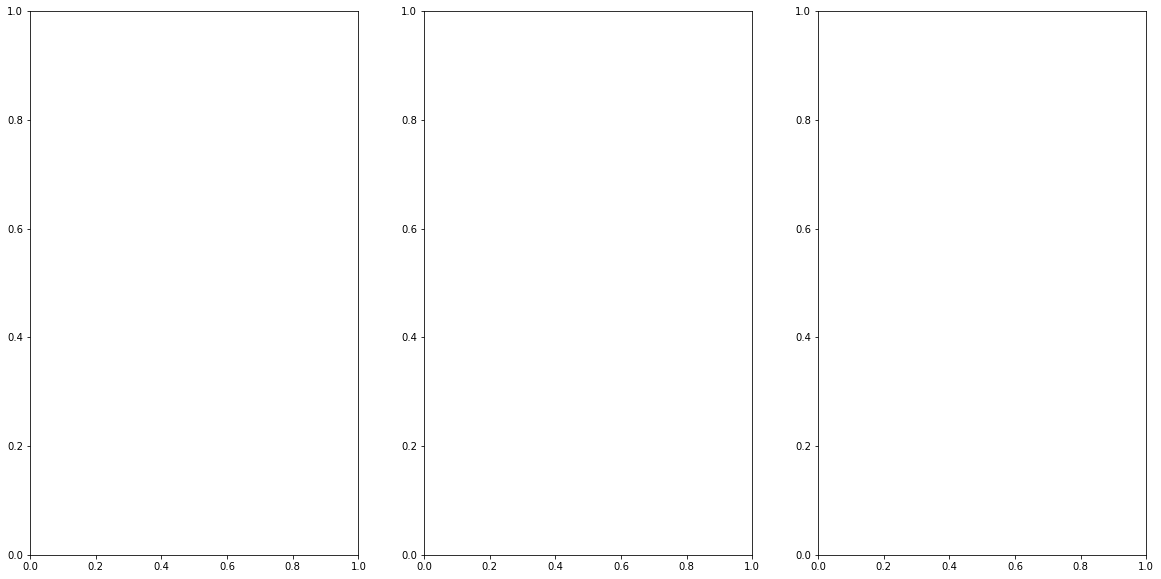

In [10]:
    f,[ax1,ax2,ax3] = plt.subplots(1,3,figsize=(20,10))
    z=[1,2,3,4,5,6,7,8]
    cmap = matplotlib.cm.get_cmap('Blues')
    normalize = matplotlib.colors.Normalize(vmin=min(z)-1, vmax=max(z))
    colors = [cmap(normalize(value)) for value in z]

    ax1.scatter(np.multiply(plt_transport,1000),np.multiply(plt_rxn,1000), color=colors,s=60)
    # plt.colorbar('Blues')
    ax1.set_title("Influence of average transport vs. reaction time on translation rate\n at different ribosome abundances")
    ax1.set_xlabel('tau_reaction (ms)')
    ax1.set_ylabel('tau_transport (ms)')
    ax1.set_xlim(0,200)
    ax1.set_ylim(0,200)

    #Draw translation rate contour
    elongation_reaction_time = np.arange(500) #500
    elongation_transport_time = np.arange(500) #500

    x=list(([],[],[],[],[],[],[],[]))
    y=list(([],[],[],[],[],[],[],[]))

    for k in range(len(x)):
        for i in elongation_reaction_time:
            for j in elongation_transport_time:
                if(elongation_reaction_time[i]+elongation_transport_time[j]==50*(k+1) and i%5==0):
                    x[k].append(elongation_reaction_time[i])
                    y[k].append(elongation_transport_time[j])
        ax1.scatter(x[k],y[k],marker='.',color='black',alpha='0.6',s=10)
    
    ###############
    
    ax2.set_title("Influence of total transport vs. reaction time in\n overall elongation rate at different ribosome abundances")
    ax2.scatter(total_rxn,total_transport,color=colors,s=60)
    ax2.set_xlim(0,1)
    ax2.set_ylim(0,1)
    ax2.set_xlabel("Fraction of total time spent by cognate tRNA in a reaction")
    ax2.set_ylabel("Fraction of total time spent by cognate tRNA freely diffusing")

In [98]:
path = "/Users/Akshay/Dropbox/Life/EndyLab/Research/TranslationDynamics/data/180912_1607/expt-10-Reactions-20180912.csv"
pathmolpos ="/Users/Akshay/Dropbox/Life/EndyLab/Research/TranslationDynamics/data/180912_1607/expt-10-Molpos-20180912.csv"
ts=1e9
totalRibosomeCollisions(path,pathmolpos,ts)

#For expt-0-Reactions-20180907.csv and moleculespos
#168 collisions for 1e-8 s threshold before repeat reaction before repeat collision allowed
#69 collisions for 1e-7 s threshold before repeat collision allowed
#114 collisions for 1e-8 threshold or 5nm space threhsold (and only checking reacA space)
#116 collisions for 1e-8 threshold or 5nm space threhsold (and checking either reacA & reacB space)
    #----the two extras are from a two crowder collision, not a ribosome crowder collision, as expected
#187 collisions for 1e-9 threshold or 5nm space threhsold (and checking either reacA & reacB space)

(15814, 9)
1000
1050
1100
1150
1200
1250
1350
1400
1450
1500
1550
1600
1650
1700
1750
1900
2000
2050
2100
2150
2200
2250
2312


2312

This section


In [116]:
ts = 1e10
path="/Users/Akshay/Dropbox/Life/EndyLab/Research/TranslationDynamics/data/moleculespos.csv"
df_molpos = pandas.read_csv(path,delimiter=" ",header=None)
df_molpos.columns=["time","species", "none","x","y","z","id"]
df_molpos["time"] = df_molpos["time"]
print(df_molpos)
a={}
a["test"]=df_molpos.loc[(df_molpos['id']==1) & (df_molpos['time'] == int(9.289030000000001e-05*ts))][['x','y','z']].values[0]
a["test1"]=df_molpos.loc[(df_molpos['id']==1) & (df_molpos['time'] == int(9.989030000000001e-05*ts))][['x','y','z']].values[0]

print(a["test"])
print(a["test1"])
print(np.linalg.norm(a["test"]-a["test1"]))

FileNotFoundError: File b'/Users/Akshay/Dropbox/Life/EndyLab/Research/TranslationDynamics/data/moleculespos.csv' does not exist

In [63]:
with pandas.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df_molpos.loc[(df_molpos['time']>595725)&(df_molpos['time']<595780)])

           time  species  none         x         y         z  id
1787175  595726        4     0  0.003334  0.019397  0.044897   1
1787176  595726        4     0  0.003578  0.017425  0.049841   2
1787177  595726        5     0  0.063594  0.003585  0.003793   3
1787178  595727        4     0  0.003450  0.019050  0.044755   1
1787179  595727        4     0  0.003296  0.017264  0.049972   2
1787180  595727        5     0  0.063594  0.003585  0.003793   3
1787181  595728        4     0  0.003572  0.018971  0.044953   1
1787182  595728        4     0  0.003395  0.017419  0.049751   2
1787183  595728        5     0  0.063594  0.003585  0.003793   3
1787184  595729        4     0  0.003640  0.018924  0.044809   1
1787185  595729        4     0  0.003335  0.017187  0.049494   2
1787186  595729        5     0  0.063594  0.003585  0.003793   3
1787187  595730        4     0  0.003696  0.018742  0.044482   1
1787188  595730        4     0  0.003029  0.017406  0.049451   2
1787189  595730        5 

In [108]:
1743

0.015630794580266866

In [ ]:
68370 4 0 0.0550995 0.04039 0.00765291 1
68370 4 0 0.0577785 0.0631067 0.0569662 2
68370 5 0 0.0635936 0.00358526 0.00379349 3
6.837e-06 rxn3_0 0.0635936 0.00358526 0.00379349 2 3 2 3

1.75139e-05 rxn3_0 0.0635936 0.00358526 0.00379349 2 3 2 3
175139 4 0 0.00728864 0.0598355 0.0117445 2
175139 4 0 0.0447228 0.0114942 0.0160601 1
175139 5 0 0.0635936 0.00358526 0.00379349 3


In [ ]:
#Store last locations of both pairs of collision reactants + time of reaction
#When same pair collision happens access that point of the table, check to make sure that
#the last collision happened at least a nanosecond before OR distance of rxn is at least a nm away.

#Or, more simply, only count a collision if it happens after a nanosecond

#These should give the same solutions at 1e-9, 1e-10,1e-11 timescales.

In [70]:
1787187  595730        4     0  0.003696  0.018742  0.044482   1
1787188  595730        4     0  0.003029  0.017406  0.049451   2

1787190  595731        4     0  0.003816  0.018829  0.044626   1
1787191  595731        4     0  0.002868  0.017043  0.049564   2

1787193  595732        4     0  0.004014  0.018552  0.044497   1
1787194  595732        4     0  0.003056  0.017258  0.049327   2

3323

In [81]:
print(np.linalg.norm([0.003696-0.003029, 0.018742-0.017406,0.044482 -0.049451 ])
,np.linalg.norm([0.003816- 0.002868,0.018829-0.017043 ,0.044626- 0.049564 ]),
np.linalg.norm([0.004014-0.003056,0.018552-0.017258, 0.044497-0.049327 ])
     
     
     )

0.0051885205984 0.00533594827561 0.0050912768536


In [ ]:
136695 4 0 0.0424045 0.0213633 0.0387385 2
136695 4 0 0.0497752 0.00486952 0.0107239 1
136695 5 0 0.0635936 0.00358526 0.00379349 3
1.36695e-05 rxn3_0 0.0635936 0.00358526 0.00379349 1 3 1 3
1.36724e-05 rxn3_0 0.0635936 0.00358526 0.00379349 1 3 1 3
136724 4 0 0.0419642 0.0220367 0.0390301 2
136724 4 0 0.0500837 0.00479868 0.0116584 1
136724 5 0 0.0635936 0.00358526 0.00379349 3

In [ ]:
99413 4 0 0.0470996 0.0238444 0.0468708 2
99413 4 0 0.0640723 0.00216209 0.0193155 1
99413 5 0 0.0635936 0.00358526 0.00379349 3

9.9413e-06 rxn3_0 0.0635936 0.00358526 0.00379349 1 3 1 3
1.35888e-05 rxn3_0 0.0635936 0.00358526 0.00379349 1 3 1 3

135888 4 0 0.0401124 0.022017 0.0396005 2
135888 4 0 0.0541059 0.00821112 0.0152551 1
135888 5 0 0.0635936 0.00358526 0.00379349 3

In [ ]:
#####Previous Analysis code#######

0.0289422


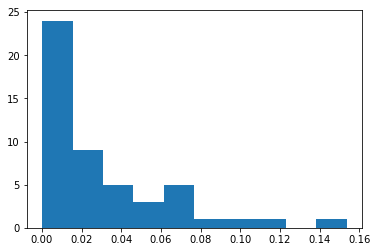

In [386]:
df = pandas.read_csv("/Users/Akshay/Dropbox/Life/EndyLab/Research/TranslationDynamics/data/expt-4-Reactions-20180906.csv",sep=" ",header=None)
df.columns=["time","rxn","x","y","z","reactantA","productA"]
t = list()
t1=list()
for i,row in df.iterrows():
    if(row["rxn"]=='rxn15'):
        t.append(row["time"])
plt.hist(t)
print(np.average(t))

In [13]:
def totalRibosomeCollisions(tRNAid,ribosomeIDList):
    df = df.sort_values(by=['reactantA'])
    rib=np.zeros(len(ribosomeIDs))
    timeavg=np.zeros(len(ribosomeIDs))
    for index, row in df.iterrows():
        if row["reactantA"] != tRNAid:
            print(row["reactantA"])
            break
        for index, ribosomeID in ribosomeIDList:
            if row["reactantB"]==ribosomeID:
                rib[index]+=1
                timeavg[index]+=row["time"]
    timeavg=np.array(timeavg)/np.array(rib)
    return rib, timeavg

In [3]:
 if row["reactantB"]==49: 
                rib[1]+=1
                timeavg[1]+=row["time"]
            if row["reactantB"]==50:
                rib[2]+=1
                timeavg[2]+=row["time"]
            if row["reactantB"]==51:
                rib[3]+=1
                timeavg[3]+=row["time"]
            if row["reactantB"]==52:
                rib[4]+=1
                timeavg[4]+=row["time"]
            if row["reactantB"]==53:
                rib[5]+=1
                timeavg[5]+=row["time"]
            if row["reactantB"]==54:
                rib[6]+=1
                timeavg[6]+=row["time"]

10

In [122]:
#Module for analysis of number of wrong collisions before correct tRNA reaches ribosome 1.4 times
#Produces graph of distribution of number of collisions in between two correct events
#Need to check to see how far the poisson (power law?) distribution is for caged events vs. free diffusing/mixing events
#to identify anomalies/spatial effects other than just being rare events being sampled.
#or we find out that the distribution is same for each ribosome, just spends less time near the ribosome.
#Fluitt uses "average", but really we have a poisson sampling rate where "avg" less meaningful

df=df.sort_values(['reactantB','time'], ascending=[True,True])
tRNAidList = list(range(1, 2))
collisionCountTot=list()
collisionCountDistrib=list()
for tRNAid in tRNAidList:
    collisionCount =0
    for index, row in df.iterrows():
        if row["reactantB"]==51:
            if row["reactantA"]!=1:
                collisionCount+=1
            if row["reactantA"]==1:
                collisionCountTot.append(collisionCount)
                collisionCount=0
    collisionCountDistrib.append(collisionCountTot)
    collisionCountTot=list()
                
print(len(collisionCountDistrib[0]))
print(sum(collisionCountDistrib[0]))
print(collisionCountDistrib)

4985
224078
[[518, 0, 0, 0, 0, 0, 0, 0, 0, 41, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 312, 0, 0, 0, 0, 0, 0, 0, 0, 12, 3, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 12, 213, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 37, 0, 0, 0, 0, 0, 0, 0, 0, 117, 0, 0, 0, 0, 0, 0, 0, 7, 60, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 70, 0, 37, 0, 0, 0, 849, 52, 0, 0, 416, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 574, 254, 0, 0, 226, 0, 0, 151, 0, 0, 0, 0, 197, 0, 0, 0, 0, 5, 0, 89, 0, 0, 0, 0, 0, 3, 0, 0, 82, 5, 0, 0, 343, 0, 0, 0, 0, 0, 0, 46, 0, 0, 732, 314, 0, 0, 0, 0, 6, 0, 1, 0, 0, 0, 0, 0, 23, 0, 105, 0, 0, 0, 0, 0, 0, 2, 0, 3, 0, 254, 0, 0, 440, 0, 1080, 0, 23, 147, 0, 0, 415, 0, 0, 0, 548, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 667, 0, 0, 0, 59, 0, 126, 318, 0, 0, 0, 504, 0, 0, 0, 13, 107, 0, 0, 0, 0, 0, 58, 0, 0, 0, 0, 0, 0, 0, 38, 0, 0, 221, 0, 0, 0, 0, 0, 0, 173, 287, 0, 0, 0, 0, 0, 0, 0, 0, 0, 168, 0, 0, 0, 0, 572, 0, 175, 0, 0, 0, 0, 24, 0, 

(array([ 897.,  320.,  103.,   34.,   12.,    6.,    0.,    0.,    1.,    0.]),
 array([   0.,   50.,  100.,  150.,  200.,  250.,  300.,  350.,  400.,
         450.,  500.]),
 <a list of 10 Patch objects>)

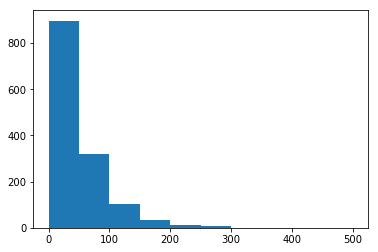

In [120]:
plt.hist(collisionCountDistrib[0],bins=10,range=(0,500)) #expt 4

(array([ 4282.,   155.,    93.,    65.,    59.,    60.,    48.,    31.,
           26.,    28.]),
 array([   0.,   50.,  100.,  150.,  200.,  250.,  300.,  350.,  400.,
         450.,  500.]),
 <a list of 10 Patch objects>)

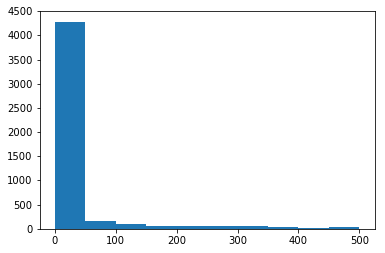

In [123]:
plt.hist(collisionCountDistrib[0],bins=10,range=(0,500)) #expt 5

[1184, 1279, 1363, 1373, 1234, 1319, 1338] [ 0.05183554  0.04899083  0.04911905  0.04938451  0.05046633  0.05205982
  0.05166268]


<function matplotlib.pyplot.tight_layout>

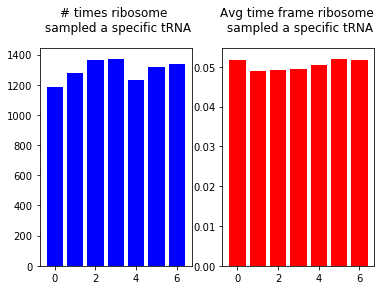

In [156]:
#Experiment 4:
print(rib,timeavg)
fig, ax = plt.subplots(1,2)
ax[0].bar([0,1,2,3,4,5,6],rib,color='b')
ax[0].set_title("# times ribosome \n sampled a specific tRNA",y=1.05)
ax[1].bar([0,1,2,3,4,5,6],timeavg,color='r')
ax[1].set_title("Avg time frame ribosome \n sampled a specific tRNA",y=1.05)
plt.tight_layout

[5273, 5050, 4424, 4985, 4862, 4502, 5213] [ 0.04796217  0.05122051  0.05047607  0.05051992  0.04876622  0.05090315
  0.05113158]


<function matplotlib.pyplot.tight_layout>

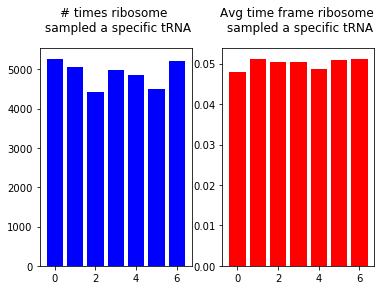

In [161]:
#Experiment 5:
print(rib,timeavg)
fig, ax = plt.subplots(1,2)
ax[0].bar([0,1,2,3,4,5,6],rib,color='b')
ax[0].set_title("# times ribosome \n sampled a specific tRNA",y=1.05)
ax[1].bar([0,1,2,3,4,5,6],timeavg,color='r')
ax[1].set_title("Avg time frame ribosome \n sampled a specific tRNA",y=1.05)
plt.tight_layout

[4061, 3469, 3937, 4304, 3863, 4476, 3922] [ 0.04862038  0.05375847  0.04359325  0.04807964  0.05175136  0.04856392
  0.05078618]


<function matplotlib.pyplot.tight_layout>

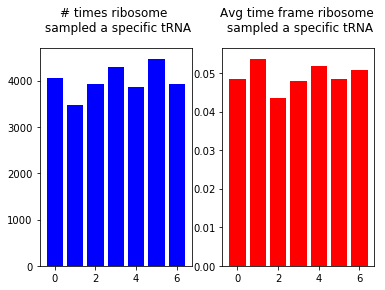

In [163]:
#Experiment 6:
print(rib,timeavg)
fig, ax = plt.subplots(1,2)
ax[0].bar([0,1,2,3,4,5,6],rib,color='b')
ax[0].set_title("# times ribosome \n sampled a specific tRNA",y=1.05)
ax[1].bar([0,1,2,3,4,5,6],timeavg,color='r')
ax[1].set_title("Avg time frame ribosome \n sampled a specific tRNA",y=1.05)
plt.tight_layout

[6564, 5549, 6191, 5654, 6230, 5810, 6691] [ 0.05085661  0.04528079  0.0482784   0.0515434   0.0467219   0.05080448
  0.0490789 ]


<function matplotlib.pyplot.tight_layout>

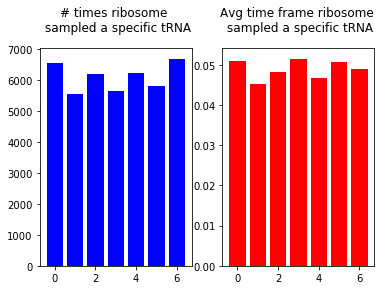

In [168]:
#Experiment 7:
print(rib,timeavg)
fig, ax = plt.subplots(1,2)
ax[0].bar([0,1,2,3,4,5,6],rib,color='b')
ax[0].set_title("# times ribosome \n sampled a specific tRNA",y=1.05)
ax[1].bar([0,1,2,3,4,5,6],timeavg,color='r')
ax[1].set_title("Avg time frame ribosome \n sampled a specific tRNA",y=1.05)
plt.tight_layout

<function matplotlib.pyplot.tight_layout>

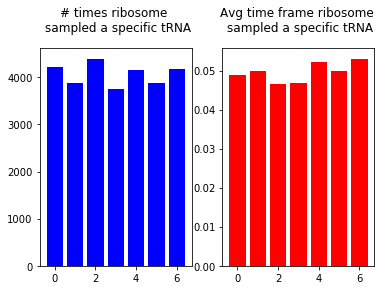

In [170]:
#Experiment 8:
fig, ax = plt.subplots(1,2)
ax[0].bar([0,1,2,3,4,5,6],rib,color='b')
ax[0].set_title("# times ribosome \n sampled a specific tRNA",y=1.05)
ax[1].bar([0,1,2,3,4,5,6],timeavg,color='r')
ax[1].set_title("Avg time frame ribosome \n sampled a specific tRNA",y=1.05)
plt.tight_layout

<function matplotlib.pyplot.tight_layout>

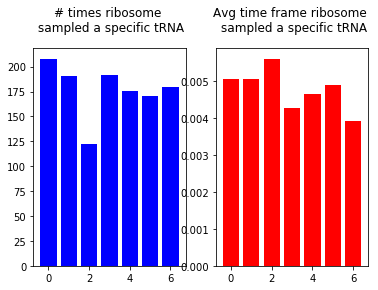

In [172]:
#Experiment 9:
fig, ax = plt.subplots(1,2)
ax[0].bar([0,1,2,3,4,5,6],rib,color='b')
ax[0].set_title("# times ribosome \n sampled a specific tRNA",y=1.05)
ax[1].bar([0,1,2,3,4,5,6],timeavg,color='r')
ax[1].set_title("Avg time frame ribosome \n sampled a specific tRNA",y=1.05)
plt.tight_layout

<function matplotlib.pyplot.tight_layout>

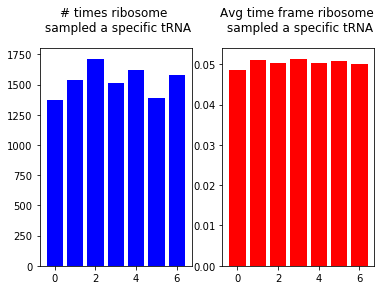

In [187]:
#Experiment 9 (100ms):
fig, ax = plt.subplots(1,2)
ax[0].bar([0,1,2,3,4,5,6],rib,color='b')
ax[0].set_title("# times ribosome \n sampled a specific tRNA",y=1.05)
ax[1].bar([0,1,2,3,4,5,6],timeavg,color='r')
ax[1].set_title("Avg time frame ribosome \n sampled a specific tRNA",y=1.05)
plt.tight_layout

<function matplotlib.pyplot.tight_layout>

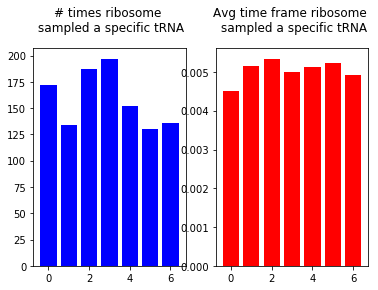

In [181]:
#Experiment 9_2: -- particle polydisperity increases sampling disparity
fig, ax = plt.subplots(1,2)
ax[0].bar([0,1,2,3,4,5,6],rib,color='b')
ax[0].set_title("# times ribosome \n sampled a specific tRNA",y=1.05)
ax[1].bar([0,1,2,3,4,5,6],timeavg,color='r')
ax[1].set_title("Avg time frame ribosome \n sampled a specific tRNA",y=1.05)
plt.tight_layout

<function matplotlib.pyplot.tight_layout>

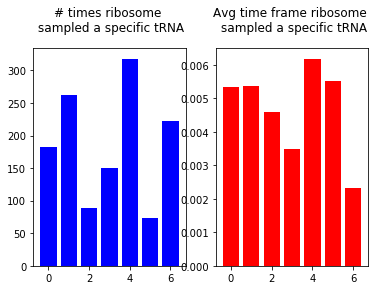

In [183]:
#Experiment 10 -- closed boundaries massively increase sampling disparity
fig, ax = plt.subplots(1,2)
ax[0].bar([0,1,2,3,4,5,6],rib,color='b')
ax[0].set_title("# times ribosome \n sampled a specific tRNA",y=1.05)
ax[1].bar([0,1,2,3,4,5,6],timeavg,color='r')
ax[1].set_title("Avg time frame ribosome \n sampled a specific tRNA",y=1.05)
plt.tight_layout

<function matplotlib.pyplot.tight_layout>

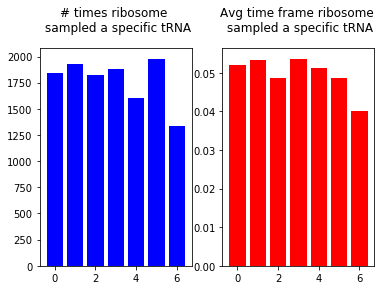

In [189]:
#Experiment 10 -- 100ms
fig, ax = plt.subplots(1,2)
ax[0].bar([0,1,2,3,4,5,6],rib,color='b')
ax[0].set_title("# times ribosome \n sampled a specific tRNA",y=1.05)
ax[1].bar([0,1,2,3,4,5,6],timeavg,color='r')
ax[1].set_title("Avg time frame ribosome \n sampled a specific tRNA",y=1.05)
plt.tight_layout

<function matplotlib.pyplot.tight_layout>

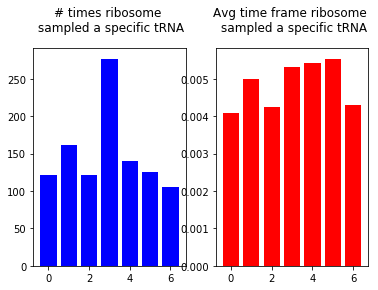

In [185]:
#Experiment 11
fig, ax = plt.subplots(1,2)
ax[0].bar([0,1,2,3,4,5,6],rib,color='b')
ax[0].set_title("# times ribosome \n sampled a specific tRNA",y=1.05)
ax[1].bar([0,1,2,3,4,5,6],timeavg,color='r')
ax[1].set_title("Avg time frame ribosome \n sampled a specific tRNA",y=1.05)
plt.tight_layout

<function matplotlib.pyplot.tight_layout>

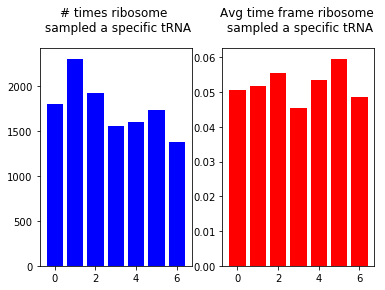

In [191]:
#Experiment 11 - 100ms
fig, ax = plt.subplots(1,2)
ax[0].bar([0,1,2,3,4,5,6],rib,color='b')
ax[0].set_title("# times ribosome \n sampled a specific tRNA",y=1.05)
ax[1].bar([0,1,2,3,4,5,6],timeavg,color='r')
ax[1].set_title("Avg time frame ribosome \n sampled a specific tRNA",y=1.05)
plt.tight_layout

[1842, 1924, 1826, 1878, 1599, 1979, 1339]


<function matplotlib.pyplot.tight_layout>

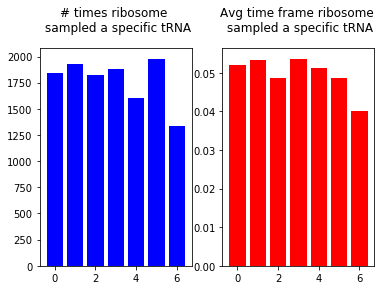

In [90]:
#Experiment 10 -- 100ms
print(rib)
fig, ax = plt.subplots(1,2)
ax[0].bar([0,1,2,3,4,5,6],rib,color='b')
ax[0].set_title("# times ribosome \n sampled a specific tRNA",y=1.05)
ax[1].bar([0,1,2,3,4,5,6],timeavg,color='r')
ax[1].set_title("Avg time frame ribosome \n sampled a specific tRNA",y=1.05)
plt.tight_layout


In [12]:
#Experiment 10 -- 100ms
print(rib)
fig, ax = plt.subplots(1,2)
ax[0].bar([0,1,2,3,4,5,6],rib,color='b')
ax[0].set_title("# times ribosome \n sampled a specific tRNA",y=1.05)
ax[1].bar([0,1,2,3,4,5,6],timeavg,color='r')
ax[1].set_title("Avg time frame ribosome \n sampled a specific tRNA",y=1.05)
plt.tight_layout


NameError: name 'rib' is not defined

In [10]:
a=np.ones([2,2])*-100
a[0,1]=20

In [11]:
a

array([[-100.,   20.],
       [-100., -100.]])